In [ ]:
# @title Mount Google Drive & Path Configuration
from google.colab import drive
drive.mount('/content/drive/')

project_path = "/content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/"
data_path = f"{project_path}/Datasets"
output_path = f"{project_path}/Outputs/EDA Outputs"
import os
os.makedirs(output_path, exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# @title Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import gc
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
RND = 42

In [ ]:
# @title Utility Fuction
# Utility helpers untuk EDA
def read_csv(path, **kwargs):
    print("Reading:", path)
    return pd.read_csv(path, **kwargs)

def save_fig(fig, name):
    p = os.path.join(output_path, name)
    fig.savefig(p, bbox_inches='tight', dpi=150)
    print("Saved plot:", p)

def missing_report(df, top=None):
    miss = df.isnull().sum()
    miss = miss[miss>0].sort_values(ascending=False)
    miss_df = miss.to_frame(name='n_missing').assign(pct=lambda d: np.round(d['n_missing'] / len(df) * 100, 2))
    return miss_df.head(top)

def quick_num_summary(df, cols=None, top=None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns
    summary = df[cols].describe().T
    summary['na_pct'] = np.round(df[cols].isna().mean() * 100, 2)
    return summary.sort_values('na_pct', ascending=False).head(top)

def top_categories(df, col, n=20):
    vc = df[col].value_counts(dropna=False).head(n)
    return vc.to_frame(col)

def rgb(r,g,b):
    return (r/255, g/255, b/255)

def hist_plot_custom(df, col, bins=50, log=False, color=(203/255,85/255,132/255)):
    fig, ax = plt.subplots(figsize=(6,3.5))
    series = df[col].dropna()
    if log:
        series = np.log1p(series[series>0])
        ax.set_title(f"{col} (log1p)")
    else:
        ax.set_title(col)
    ax.grid(False)
    fig.patch.set_alpha(0)
    ax.set_facecolor('none')
    sns.histplot(series, bins=bins, kde=False, ax=ax,  color=color)
    return fig, ax

def barplot_cat_target(df, cat_col, target_col='TARGET', topn=15, color=(203/255,85/255,132/255)):
    order = df[cat_col].value_counts().index[:topn]
    ct = pd.crosstab(df[cat_col], df[target_col]).loc[order]
    ct_norm = ct.div(ct.sum(axis=1), axis=0)

    if 1 in ct_norm.columns:
        target_positive = 1
    else:
        target_positive = ct_norm.columns.max()

    fig, ax = plt.subplots(figsize=(8, max(4,0.3*len(order))))
    ct_norm[target_positive].plot(kind='barh', ax=ax, color=color)
    ax.set_xlabel(f"PERC {target_col}={target_positive} per {cat_col}")
    ax.set_title(f"{cat_col} vs {target_col} (top {topn})")
    return fig, ax

In [ ]:
# @title Load Dataset

app_train = pd.read_csv(os.path.join(data_path, "application_train.csv"))
app_test  = pd.read_csv(os.path.join(data_path, "application_test.csv"))
bureau    = pd.read_csv(os.path.join(data_path, "bureau.csv"))
bbal      = pd.read_csv(os.path.join(data_path, "bureau_balance.csv"))
prev      = pd.read_csv(os.path.join(data_path, "previous_application.csv"))
pos       = pd.read_csv(os.path.join(data_path, "POS_CASH_balance.csv"))
cc        = pd.read_csv(os.path.join(data_path, "credit_card_balance.csv"))
ins       = pd.read_csv(os.path.join(data_path, "installments_payments.csv"))
subs      = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# summary columns and rows
for name, df in [
    ('app_train', app_train),
    ('app_test', app_test),
    ('bureau', bureau),
    ('bbal', bbal),
    ('prev', prev),
    ('pos', pos),
    ('cc', cc),
    ('ins', ins),
    ('subs', subs)
]:
    print(f"{name:8s} shape: {df.shape}")

app_train shape: (307511, 122)
app_test shape: (48744, 121)
bureau   shape: (1716428, 17)
bbal     shape: (27299925, 3)
prev     shape: (1670214, 37)
pos      shape: (10001358, 8)
cc       shape: (3840312, 23)
ins      shape: (13605401, 8)
subs     shape: (48744, 2)


# **Exploratory Data Analysis**

## EDA (application_train|test)

In [ ]:
# @title Overview

# Feature TARGET
print("application_train Columns:", len(app_train.columns))
print("TARGET Distribution:")
print(app_train['TARGET'].value_counts(dropna=False))

# Missing values
mr = missing_report(app_train, top=None)
display(mr.head(50))

# Numeric summary
num_sum = quick_num_summary(app_train, top=None)
display(num_sum.head(50))

application_train Columns: 122
TARGET Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64


,n_missing,pct
COMMONAREA_MEDI,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_AVG,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35


,count,mean,std,min,25%,50%,75%,max,na_pct
COMMONAREA_AVG,92646.0,0.044621,0.076036,0.000000,0.007800,0.021100,0.051500,1.000000,69.87
COMMONAREA_MODE,92646.0,0.042553,0.074445,0.000000,0.007200,0.019000,0.049000,1.000000,69.87
COMMONAREA_MEDI,92646.0,0.044595,0.076144,0.000000,0.007900,0.020800,0.051300,1.000000,69.87
NONLIVINGAPARTMENTS_MODE,93997.0,0.008076,0.046276,0.000000,0.000000,0.000000,0.003900,1.000000,69.43
NONLIVINGAPARTMENTS_AVG,93997.0,0.008809,0.047732,0.000000,0.000000,0.000000,0.003900,1.000000,69.43
NONLIVINGAPARTMENTS_MEDI,93997.0,0.008651,0.047415,0.000000,0.000000,0.000000,0.003900,1.000000,69.43
LIVINGAPARTMENTS_AVG,97312.0,0.100775,0.092576,0.000000,0.050400,0.075600,0.121000,1.000000,68.35
LIVINGAPARTMENTS_MODE,97312.0,0.105645,0.097880,0.000000,0.054200,0.077100,0.131300,1.000000,68.35
LIVINGAPARTMENTS_MEDI,97312.0,0.101954,0.093642,0.000000,0.051300,0.076100,0.123100,1.000000,68.35
FLOORSMIN_AVG,98869.0,0.231894,0.161380,0.000000,0.083300,0.208300,0.375000,1.000000,67.85


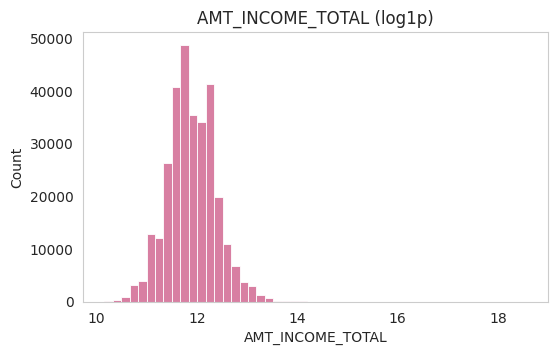

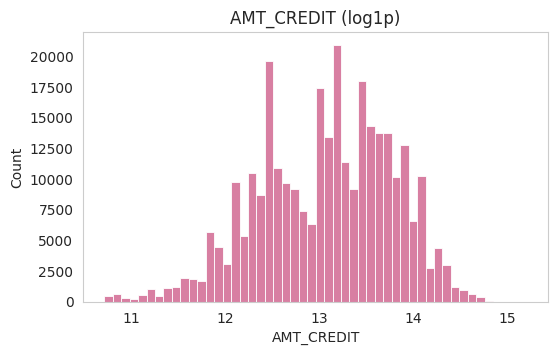

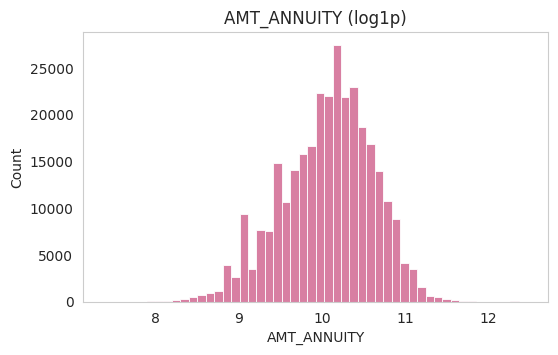

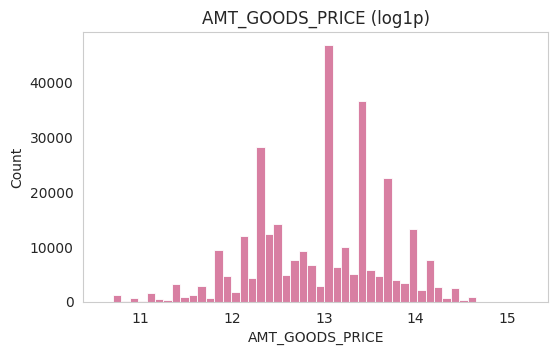

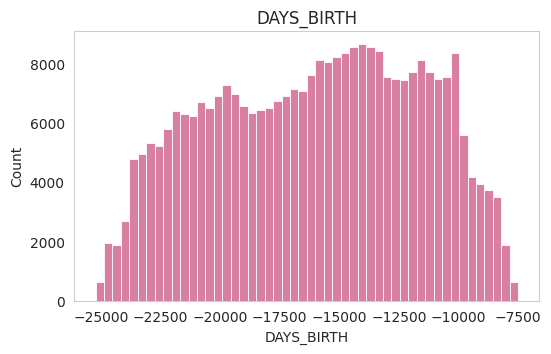

In [ ]:
# @title Distribution histograms
color_hist = rgb(203, 85, 132)
for col, log in [('AMT_INCOME_TOTAL', True),
                 ('AMT_CREDIT', True),
                 ('AMT_ANNUITY', True),
                 ('AMT_GOODS_PRICE', True),
                 ('DAYS_BIRTH', False)]:
    if col in app_train.columns:
        fig, ax = hist_plot_custom(app_train, col, log=log, color=color_hist)
        plt.show()
        plt.close(fig)

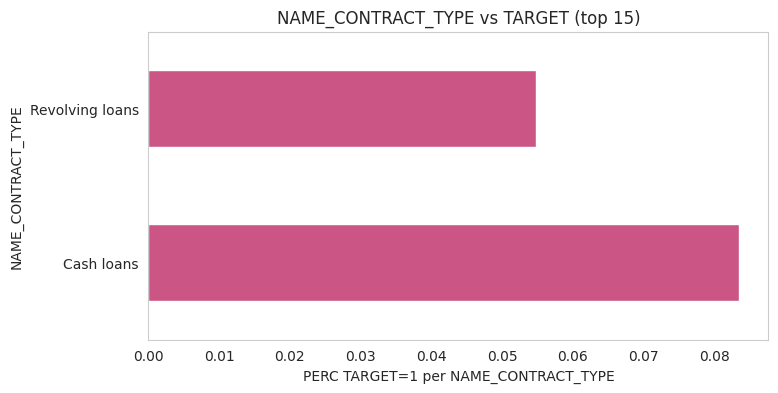

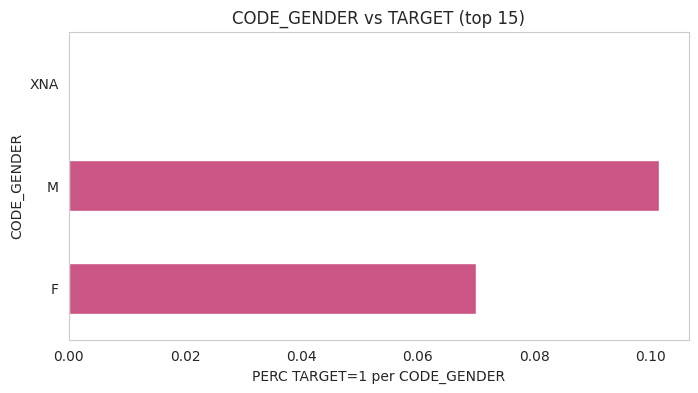

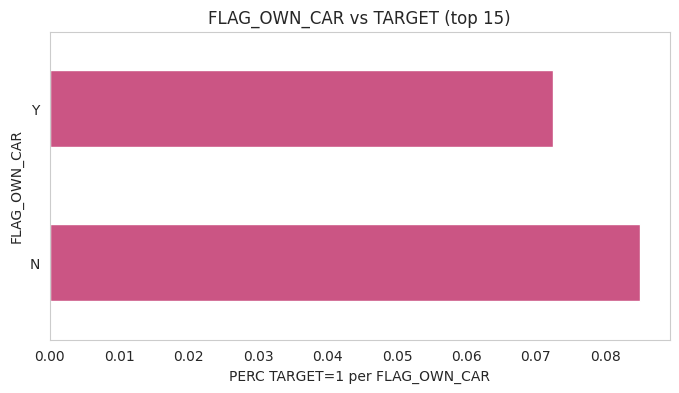

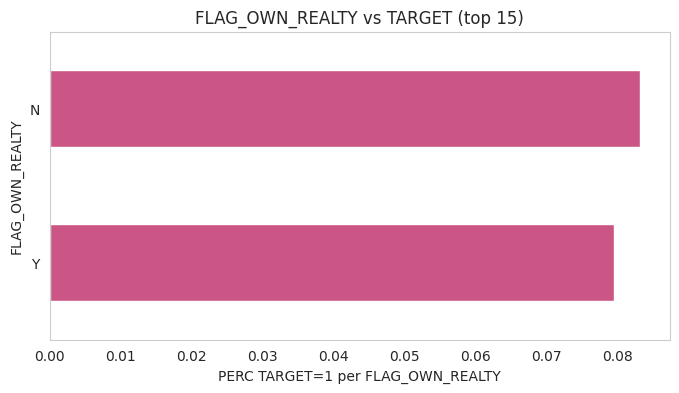

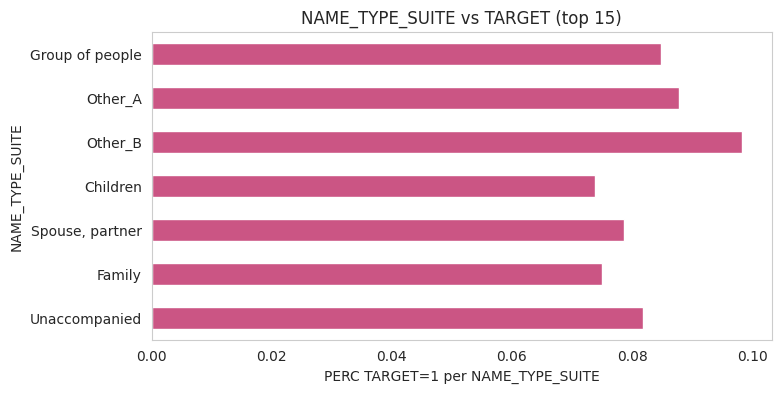

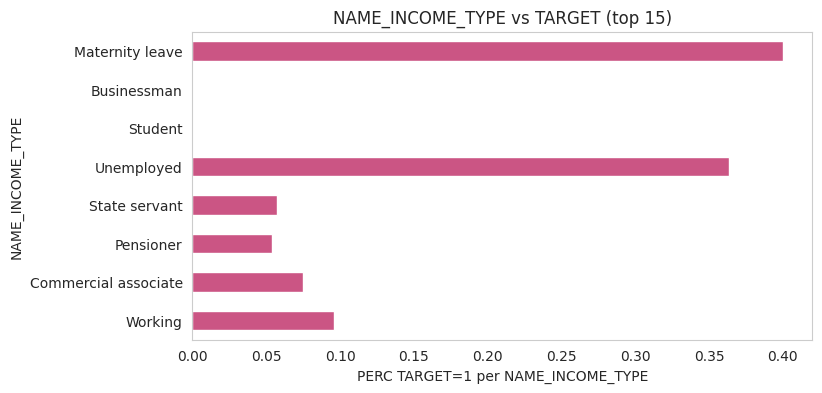

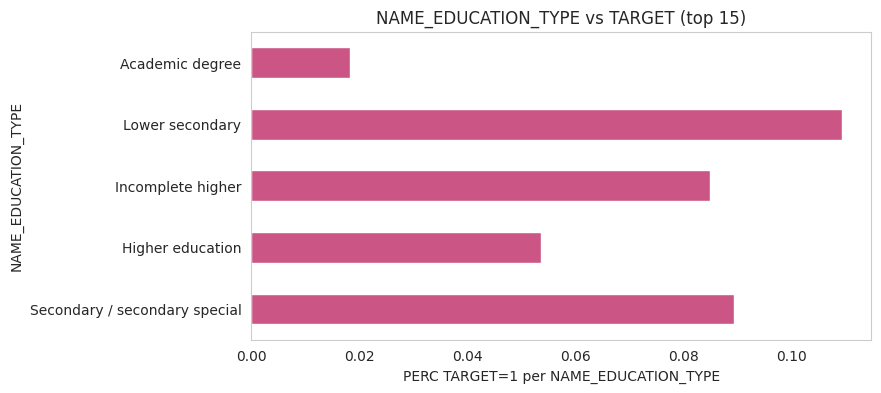

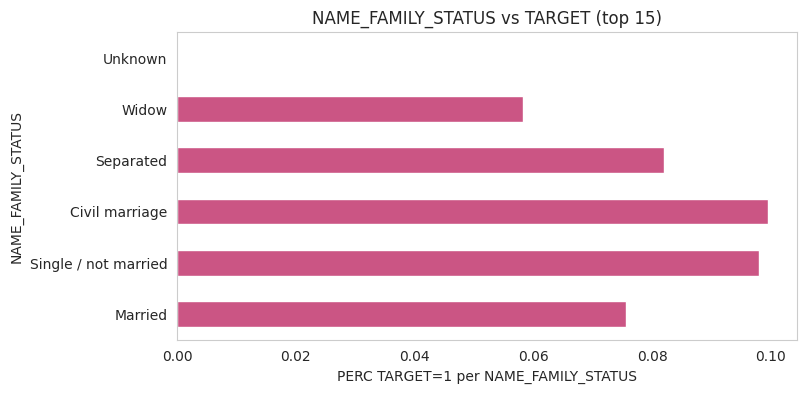

In [ ]:
# @title Categorical top frequency + relationship with TARGET
color_bar = (203/255, 85/255, 132/255)
cat_cols = app_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols[:8]:
    vc = top_categories(app_train, col, n=20)
    vc.to_csv(os.path.join(output_path, f"application_train_cat_counts_{col}.csv"))
    fig, ax = barplot_cat_target(app_train[[col,'TARGET']].dropna(), col, 'TARGET', topn=15, color=color_bar)
    ax.grid(False)
    plt.show()
    plt.close(fig)

In [ ]:
# @title Data Balanced or Imbalanced
# Hitung jumlah tiap kategori TARGET
temp = app_train["TARGET"].value_counts()
label_map = {0: "Loan Repaid", 1: "Loan Not Repaid"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
# Plot pie chart
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)']
fig = px.pie(df,
             names='labels',
             values='values',
             color_discrete_sequence=colors,
             title='Loan Repaid or Not')
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(text='Loan Repaid or Not', x=0.5, xanchor='center', yanchor='top', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color='black')),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Who Accompanied Client When Applying for The Application
# Hitung persentase tiap kategori
temp = app_train["NAME_TYPE_SUITE"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Who Accompanied Client When Applying for The Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Name of type of the Suite',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Name of type of the Suite',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='name_type_suite_percent')

In [ ]:
# @title Distribution of Name of Type of The Suite in Terms of Loan Repayment
temp = app_train["NAME_TYPE_SUITE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_TYPE_SUITE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_TYPE_SUITE"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout( title=dict(text="Distribution of Name of type of the Suite in terms of Loan Repayment (%)",
                               x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')), barmode='group',
                    xaxis=dict(title='Name of type of the Suite',
                               titlefont=dict(size=12, color='rgb(1,1,1)'),
                               tickfont=dict(size=10, color='rgb(1,1,1)'),
                               showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                    yaxis=dict(title='Percentage (%)',
                               titlefont=dict(size=12, color='rgb(1,1,1)'),
                               tickfont=dict(size=10, color='rgb(1,1,1)'),
                               showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                    legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                    plot_bgcolor='rgba(0,0,0,0)',
                    paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='name_type_suite_target')

In [ ]:
# @title Type of Loans
# Hitung jumlah tiap kategori TARGET
temp = app_train["NAME_CONTRACT_TYPE"].value_counts()
label_map = {"Cash loans": "Cash Loans", "Revolving loans": "Revolving Loans"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
# Plot pie chart
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)']
fig = px.pie(df,
             names='labels',
             values='values',
             color_discrete_sequence=colors,
             title='Types of Loan')
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(text='Types of Loan', x=0.5, xanchor='center', yanchor='top', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color='black')),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Purpose of Loan
# Hitung jumlah tiap kategori
temp1 = app_train["FLAG_OWN_CAR"].value_counts()
temp2 = app_train["FLAG_OWN_REALTY"].value_counts()
label_map = {"Y": "Yes", "N": "No"}
color_map  = {"Yes":"rgb(203, 85, 132)", "No":"rgb(43, 58, 111)" }
fig = go.Figure()
# Donut Own Car
labels1 = temp1.index.map(label_map)
colors1 = [color_map[l] for l in labels1]
fig.add_trace(go.Pie(labels=labels1, values=temp1.values, name="Own Car", hole=0.5, textinfo="percent", marker=dict(colors=colors1), domain={"x": [0, 0.5]}))
# Donut Own Realty
labels2 = temp2.index.map(label_map)
colors2 = [color_map[l] for l in labels2]
fig.add_trace(go.Pie(labels=labels2, values=temp2.values, name="Own Realty", hole=0.5, textinfo="percent", marker=dict(colors=colors2), domain={"x": [0.5, 1]}))
# Layout
fig.update_layout(title=dict(text="Ownership of Car and Realty",
                             x=0.5, xanchor="center", font=dict(color="black")),
                  annotations=[dict(text="Own Car", x=0.20, y=0.5, showarrow=False),
                               dict(text="Own Realty", x=0.8, y=0.5, showarrow=False)],
                  legend=dict(orientation="h", yanchor="bottom", y=-0.15, xanchor="center", x=0.5,
                              font=dict(color="black")),
                  paper_bgcolor="rgba(0,0,0,0)",
                  plot_bgcolor="rgba(0,0,0,0)")
fig.show()

In [ ]:
# @title Income sources of Applicant's Who Applied for Loan
temp = app_train["NAME_INCOME_TYPE"].value_counts()
label_map = {"Working": "Working",
             "Commercial associate": "Commercial Associate",
             "Pensioner": "Pensioner",
             "State servant": "State Servant",
             "Unemployed": "Unemployed",
             "Student": "Student",
             "Businessman": "Businessman",
             "Maternity leave": "Maternity leave"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)',
          'rgb(220, 152, 141)', 'rgb(126, 188, 153)', 'rgb(238, 160, 95)', 'rgb(128, 165, 131)']
# Pie chart
fig = px.pie(df,names='labels', values='values', color_discrete_sequence=colors, title="Income sources of Applicant's")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Distribution of Income Source in Terms of Loan Repayment
temp = app_train["NAME_INCOME_TYPE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_INCOME_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_INCOME_TYPE"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Distribution of Income Sources in Terms of Loan Repayment (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')), barmode='group',
                   xaxis=dict(title='Income Source',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage (%)',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='income_type_target')

In [ ]:
# @title Family Status of Applicant's
temp = app_train["NAME_FAMILY_STATUS"].value_counts()
label_map = {"Single / not married": "Single / Not Married",
             "Married": "Married",
             "Civil marriage": "Civil Marriage",
             "Separated": "Separated",
             "Widow": "Widow"}
df = pd.DataFrame({'labels': temp.index.map(label_map),'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)', 'rgb(126, 188, 153)', 'rgb(220, 152, 141)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors, title="Family Status of Applicant's")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Distribution of Family Status in Terms of Loan Repayment
temp = app_train["NAME_FAMILY_STATUS"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_FAMILY_STATUS"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_FAMILY_STATUS"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Distribution of Family Status in Terms of Loan Repayment (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')), barmode='group',
                   xaxis=dict(title='Family Status',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage (%)',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='family_status_target')

In [ ]:
# @title Occupation of Applicant's Who Applied for Loan
temp = app_train["OCCUPATION_TYPE"].value_counts()
trace = go.Bar(x=temp.index, y=temp.values, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Occupation of Applicant's",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Occupation',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Count of Occupation',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='occupation_count')

In [ ]:
# @title Distribution of Occupation in Terms of Loan Repayment
temp = app_train["OCCUPATION_TYPE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["OCCUPATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["OCCUPATION_TYPE"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Distribution of Occupation in Terms of Loan Repayment (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')), barmode='group',
                   xaxis=dict(title="Occupation of Applicant's",
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage (%)',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='occupation_target')

In [ ]:
# @title Education of Applicant's
temp = app_train["NAME_EDUCATION_TYPE"].value_counts()
label_map = {"Secondary / secondary special": "Secondary",
             "Higher education": "Higher Education",
             "Incomplete higher": "Incomplete Higher",
             "Lower secondary": "Lower Secondary",
             "Academic degree": "Academic Degree"}
df = pd.DataFrame({'labels': temp.index.map(label_map),'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)', 'rgb(126, 188, 153)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors, title="Education of Applicant's")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Distribution of Education in Terms of Loan Repayment
temp = app_train["NAME_EDUCATION_TYPE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_EDUCATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_EDUCATION_TYPE"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Distribution of Education in Terms of Loan Repayment (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),barmode='group',
                   xaxis=dict(title="Education of Applicant's",
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage (%)',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='education_target')

In [ ]:
# @title Type of House of Applicant's Who Applied for Loan
temp = app_train["NAME_HOUSING_TYPE"].value_counts()
label_map = {"House / apartment": "House/Apartment",
             "With parents": "With Parents",
             "Municipal apartment": "Municipal Apartment",
             "Rented apartment": "Rented Apartment",
             "Office apartment": "Office Apartment",
             "Co-op apartment": "Co-op Apartment"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)', 'rgb(126, 188, 153)', 'rgb(220, 152, 141)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors, title="Type of House of Applicant's")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Distribution of Housing Type in Terms of Loan Repayment
temp = app_train["NAME_HOUSING_TYPE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["NAME_HOUSING_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["NAME_HOUSING_TYPE"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Distribution of Housing Type in Terms of Loan Repayment (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')), barmode='group',
                   xaxis=dict(title="Types of House",
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage (%)',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='housing_type_target')

In [ ]:
# @title Types of Organizations who applied for loan
temp = app_train["ORGANIZATION_TYPE"].value_counts()
trace = go.Bar(x=temp.index, y=temp.values, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Types of Organizations of Applicant's",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Organization Name',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Count of Organizations',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='organization_count')

In [ ]:
# @title Distribution of Organization Type in Terms of Loan Repayment
temp = app_train["ORGANIZATION_TYPE"].value_counts()
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train["TARGET"][app_train["ORGANIZATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(app_train["TARGET"][app_train["ORGANIZATION_TYPE"]==val] == 0))
trace1 = go.Bar(x=temp.index, y=(np.array(temp_y0) / temp.sum()) * 100, name='Loan Repaid (NO)', marker=dict(color='rgb(43, 58, 111)'))
trace2 = go.Bar(x=temp.index, y=(np.array(temp_y1) / temp.sum()) * 100, name='Loan Not Repaid (YES)', marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Distribution of Organization Type in Terms of Loan Repayment (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')), barmode='group',
                   xaxis=dict(title="Types of Organizations",
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=9, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage (%)',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   legend=dict(yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)',
                   width=1100, height=600)
fig = go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig, filename='organization_type_target')

## EDA (bureau & bureau_balance)

In [ ]:
# @title bureau Overview
print("bureau shape:", bureau.shape)
display(missing_report(bureau).head(30))
display(quick_num_summary(bureau, top=30))
display(
    bureau[['AMT_CREDIT_SUM',
            'AMT_CREDIT_SUM_DEBT',
            'AMT_CREDIT_SUM_OVERDUE']].describe())

bureau shape: (1716428, 17)


,n_missing,pct
AMT_ANNUITY,1226791,71.47
AMT_CREDIT_MAX_OVERDUE,1124488,65.51
DAYS_ENDDATE_FACT,633653,36.92
AMT_CREDIT_SUM_LIMIT,591780,34.48
AMT_CREDIT_SUM_DEBT,257669,15.01
DAYS_CREDIT_ENDDATE,105553,6.15
AMT_CREDIT_SUM,13,0.00


,count,mean,std,min,25%,50%,75%,max,na_pct
AMT_ANNUITY,489637.0,1.571276e+04,3.258269e+05,0.000,0.00,0.0,13500.00,1.184534e+08,71.47
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08,65.51
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00,36.92
AMT_CREDIT_SUM_LIMIT,1124648.0,6.229515e+03,4.503203e+04,-586406.115,0.00,0.0,0.00,4.705600e+06,34.48
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08,15.01
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04,6.15
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00,0.00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03,0.00
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05,0.00
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06,0.00


,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE
count,1.716415e+06,1.458759e+06,1.716428e+06
mean,3.549946e+05,1.370851e+05,3.791276e+01
std,1.149811e+06,6.774011e+05,5.937650e+03
min,0.000000e+00,-4.705600e+06,0.000000e+00
25%,5.130000e+04,0.000000e+00,0.000000e+00
50%,1.255185e+05,0.000000e+00,0.000000e+00
75%,3.150000e+05,4.015350e+04,0.000000e+00
max,5.850000e+08,1.701000e+08,3.756681e+06


In [ ]:
# @title Credit Active Distribution
credit_active_counts = bureau['CREDIT_ACTIVE'].value_counts().reset_index()
credit_active_counts.columns = ['CREDIT_ACTIVE', 'Count']
fig = px.bar(credit_active_counts,
             x="CREDIT_ACTIVE", y="Count",
             color_discrete_sequence=['rgb(203, 85, 132)'],
             title="Bureau: Credit Active Distribution")
fig.update_layout(title=dict(text="Bureau: Credit Active Distribution",
                             x=0.5, xanchor='center', font=dict(size=14, color='black')),
                  xaxis=dict(title="Count",
                             titlefont=dict(size=12, color='black'),
                             tickfont=dict(size=11, color='black'),
                             showgrid=False, showline=True, linecolor='black'),
                  yaxis=dict(title="Credit Active Status",
                             titlefont=dict(size=12, color='black'),
                             tickfont=dict(size=11, color='black'),
                             showgrid=False, showline=True, linecolor='black'),
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  width=700, height=400)
fig.show()

In [ ]:
# @title bureau_balance overview
print("bureau_balance shape:", bbal.shape)
display(bbal['STATUS'].value_counts().to_frame('count').T)
display(missing_report(bbal).head(20).T)

bureau_balance shape: (27299925, 3)


STATUS,C,0,X,1,5,2,3,4
count,13646993,7499507,5810482,242347,62406,23419,8924,5847


""
n_missing
pct


In [ ]:
# @title STATUS Distribution
status_counts = bbal['STATUS'].value_counts().reset_index()
status_counts.columns = ['STATUS', 'Count']
fig = px.bar(status_counts,
             x="STATUS", y="Count",
             color_discrete_sequence=['rgb(203, 85, 132)'],
             title="Bureau Balance: STATUS Distribution")
fig.update_layout(title=dict(text="Bureau Balance: STATUS Distribution",
                             x=0.5, xanchor='center', font=dict(size=14, color='black')),
                  xaxis=dict(title="STATUS",
                             titlefont=dict(size=12, color='black'),
                             tickfont=dict(size=11, color='black'),
                             showgrid=False, showline=True, linecolor='black'),
                  yaxis=dict(title="Jumlah",
                             titlefont=dict(size=12, color='black'),
                             tickfont=dict(size=11, color='black'),
                             showgrid=False, showline=True, linecolor='black'),
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  width=700, height=400)
fig.show()

In [ ]:
# @title Aggregate to SK_ID_CURR
# Aggregate bureau_balance per SK_ID_BUREAU
agg_bb = bbal.groupby('SK_ID_BUREAU').agg(
    bb_months_count=('MONTHS_BALANCE', 'count'),
    bb_status_0=('STATUS', lambda x: (x == '0').sum()),
    bb_status_1=('STATUS', lambda x: (x == '1').sum()),
    bb_status_2=('STATUS', lambda x: (x == '2').sum()),
    bb_status_3=('STATUS', lambda x: (x == '3').sum()),
    bb_status_4=('STATUS', lambda x: (x == '4').sum()),
    bb_status_5=('STATUS', lambda x: (x == '5').sum()),
    bb_status_C=('STATUS', lambda x: (x == 'C').sum()),
    bb_status_X=('STATUS', lambda x: (x == 'X').sum())
).reset_index()

# Merge ke bureau
bureau_merged = bureau.merge(agg_bb, on='SK_ID_BUREAU', how='left')

# Aggregate bureau per SK_ID_CURR
agg_bureau = bureau_merged.groupby('SK_ID_CURR').agg(
    bureau_count=('SK_ID_BUREAU', 'count'),
    bureau_amt_credit_sum=('AMT_CREDIT_SUM', 'sum'),
    bureau_amt_credit_mean=('AMT_CREDIT_SUM', 'mean'),
    bureau_amt_credit_max=('AMT_CREDIT_SUM', 'max'),
    bureau_amt_credit_debt_sum=('AMT_CREDIT_SUM_DEBT', 'sum'),
    bureau_amt_credit_debt_mean=('AMT_CREDIT_SUM_DEBT', 'mean'),
    bureau_amt_credit_overdue_sum=('AMT_CREDIT_SUM_OVERDUE', 'sum'),
    bureau_amt_credit_overdue_mean=('AMT_CREDIT_SUM_OVERDUE', 'mean'),
    bureau_credit_day_overdue_mean=('CREDIT_DAY_OVERDUE', 'mean'),
    bureau_cnt_credit_prolong_sum=('CNT_CREDIT_PROLONG', 'sum'),
    bureau_bb_months_count_mean=('bb_months_count', 'mean'),
    bureau_bb_status_0_mean=('bb_status_0', 'mean'),
    bureau_bb_status_1_mean=('bb_status_1', 'mean'),
    bureau_bb_status_2_mean=('bb_status_2', 'mean'),
    bureau_bb_status_3_mean=('bb_status_3', 'mean'),
    bureau_bb_status_4_mean=('bb_status_4', 'mean'),
    bureau_bb_status_5_mean=('bb_status_5', 'mean')
).reset_index()

# Rapikan nama kolom
#agg_bureau.columns = ['_'.join(col).strip() for col in agg_bureau.columns.values]
#agg_bureau.reset_index(inplace=True)

# Simpan semua hasil ke CSV
agg_bb.to_csv(os.path.join(output_path, "bureau_balance_agg_per_bureau.csv"), index=False)
bureau_merged.to_csv(os.path.join(output_path, "bureau_with_bb.csv"), index=False)
agg_bureau.to_csv(os.path.join(output_path, "bureau_agg_per_curr.csv"), index=False)

# Tampilkan sampel di notebook
print("📌 Bureau Balance aggregated per SK_ID_BUREAU")
display(agg_bb.head())
print("\n📌 Bureau merged with Bureau Balance")
display(bureau_merged.head())
print("\n📌 Bureau aggregated per SK_ID_CURR")
display(agg_bureau.head())

📌 Bureau Balance aggregated per SK_ID_BUREAU


,SK_ID_BUREAU,bb_months_count,bb_status_0,bb_status_1,bb_status_2,bb_status_3,bb_status_4,bb_status_5,bb_status_C,bb_status_X
0,5001709,97,0,0,0,0,0,0,86,11
1,5001710,83,5,0,0,0,0,0,48,30
2,5001711,4,3,0,0,0,0,0,0,1
3,5001712,19,10,0,0,0,0,0,9,0
4,5001713,22,0,0,0,0,0,0,0,22



📌 Bureau merged with Bureau Balance


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_ANNUITY,bb_months_count,bb_status_0,bb_status_1,bb_status_2,bb_status_3,bb_status_4,bb_status_5,bb_status_C,bb_status_X
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



📌 Bureau aggregated per SK_ID_CURR


,SK_ID_CURR,bureau_count,bureau_amt_credit_sum,bureau_amt_credit_mean,bureau_amt_credit_max,bureau_amt_credit_debt_sum,bureau_amt_credit_debt_mean,bureau_amt_credit_overdue_sum,bureau_amt_credit_overdue_mean,bureau_credit_day_overdue_mean,bureau_cnt_credit_prolong_sum,bureau_bb_months_count_mean,bureau_bb_status_0_mean,bureau_bb_status_1_mean,bureau_bb_status_2_mean,bureau_bb_status_3_mean,bureau_bb_status_4_mean,bureau_bb_status_5_mean
0,100001,7,1453365.000,207623.571429,378000.0,596686.5,85240.928571,0.0,0.0,0.0,0,24.571429,4.428571,0.142857,0.0,0.0,0.0,0.0
1,100002,8,865055.565,108131.945625,450000.0,245781.0,49156.200000,0.0,0.0,0.0,0,13.750000,5.625000,3.375000,0.0,0.0,0.0,0.0
2,100003,4,1017400.500,254350.125000,810000.0,0.0,0.000000,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,2,189037.800,94518.900000,94537.8,0.0,0.000000,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,3,657126.000,219042.000000,568800.0,568408.5,189469.500000,0.0,0.0,0.0,0,7.000000,4.666667,0.000000,0.0,0.0,0.0,0.0


## EDA (previous_application)

In [ ]:
# @title Overview
print("previous_application shape:", prev.shape)
print("Total columns:", len(prev.columns))

# Missing values
mr_prev = missing_report(prev, top=None)
display(mr_prev.head(50))

# Numeric summary
num_sum_prev = quick_num_summary(prev, top=None)
display(num_sum_prev.head(50))

# Summary of key numeric columns
key_cols = ['AMT_APPLICATION', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_DECISION', 'CNT_PAYMENT']
key_cols_exist = [c for c in key_cols if c in prev.columns]
print("\nKey numeric columns summary:")
display(prev[key_cols_exist].describe().T)

previous_application shape: (1670214, 37)
Total columns: 37


,n_missing,pct
RATE_INTEREST_PRIVILEGED,1664263,99.64
RATE_INTEREST_PRIMARY,1664263,99.64
AMT_DOWN_PAYMENT,895844,53.64
RATE_DOWN_PAYMENT,895844,53.64
NAME_TYPE_SUITE,820405,49.12
DAYS_LAST_DUE,673065,40.30
DAYS_FIRST_DRAWING,673065,40.30
DAYS_FIRST_DUE,673065,40.30
DAYS_TERMINATION,673065,40.30
NFLAG_INSURED_ON_APPROVAL,673065,40.30


,count,mean,std,min,25%,50%,75%,max,na_pct
RATE_INTEREST_PRIVILEGED,5951.0,7.735025e-01,0.100879,3.731501e-01,7.156448e-01,8.350951e-01,8.525370e-01,1.000,99.64
RATE_INTEREST_PRIMARY,5951.0,1.883569e-01,0.087671,3.478125e-02,1.607163e-01,1.891222e-01,1.933299e-01,1.000,99.64
AMT_DOWN_PAYMENT,774370.0,6.697402e+03,20921.495410,-9.000000e-01,0.000000e+00,1.638000e+03,7.740000e+03,3060045.000,53.64
RATE_DOWN_PAYMENT,774370.0,7.963682e-02,0.107823,-1.497876e-05,0.000000e+00,5.160508e-02,1.089091e-01,1.000,53.64
DAYS_LAST_DUE_1ST_VERSION,997149.0,3.376777e+04,106857.034789,-2.801000e+03,-1.242000e+03,-3.610000e+02,1.290000e+02,365243.000,40.30
DAYS_TERMINATION,997149.0,8.199234e+04,153303.516729,-2.874000e+03,-1.270000e+03,-4.990000e+02,-4.400000e+01,365243.000,40.30
NFLAG_INSURED_ON_APPROVAL,997149.0,3.325702e-01,0.471134,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000,40.30
DAYS_FIRST_DRAWING,997149.0,3.422099e+05,88916.115834,-2.922000e+03,3.652430e+05,3.652430e+05,3.652430e+05,365243.000,40.30
DAYS_FIRST_DUE,997149.0,1.382627e+04,72444.869708,-2.892000e+03,-1.628000e+03,-8.310000e+02,-4.110000e+02,365243.000,40.30
DAYS_LAST_DUE,997149.0,7.658240e+04,149647.415123,-2.889000e+03,-1.314000e+03,-5.370000e+02,-7.400000e+01,365243.000,40.30



Key numeric columns summary:


,count,mean,std,min,25%,50%,75%,max
AMT_APPLICATION,1670214.0,175233.860360,292779.762387,0.0,18720.00,71046.0,180360.00,6905160.000
AMT_CREDIT,1670213.0,196114.021218,318574.616546,0.0,24160.50,80541.0,216418.50,6905160.000
AMT_ANNUITY,1297979.0,15955.120659,14782.137335,0.0,6321.78,11250.0,20658.42,418058.145
DAYS_DECISION,1670214.0,-880.679668,779.099667,-2922.0,-1300.00,-581.0,-280.00,-1.000
CNT_PAYMENT,1297984.0,16.054082,14.567288,0.0,6.00,12.0,24.00,84.000


In [ ]:
# Check unique values in important categorical columns
cat_check = ['NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO']
for col in cat_check:
    if col in prev.columns:
        print(f"\nValue counts for {col}:")
        print(prev[col].value_counts(dropna=False))


Value counts for NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: count, dtype: int64

Value counts for NAME_CONTRACT_STATUS:
NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

Value counts for NAME_PAYMENT_TYPE:
NAME_PAYMENT_TYPE
Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: count, dtype: int64

Value counts for NAME_CLIENT_TYPE:
NAME_CLIENT_TYPE
Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: count, dtype: int64

Value counts for NAME_PORTFOLIO:
NAME_PORTFOLIO
POS      691011
Cash     461563
XNA      372230
Cards    144985
Cars        425
Name: count, dtype: int64


In [ ]:
# @title Contract Product Type of Previous Application
temp = prev["NAME_CONTRACT_TYPE"].value_counts()
label_map = {"Cash loans": "Cash Loans",
             "Consumer loans": "Consumer loans",
             "Revolving loans": "Revolving Loans",
             "XNA": "XNA"}  # sesuaikan jika ada label lain
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
# Warna yang digunakan
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors, title="Contract product type of previous application")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Day of Week Distribution for Previous Applications
temp = prev["WEEKDAY_APPR_PROCESS_START"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="On Which Day Highest Number of Clients Applied in Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Day of the Week',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='weekday_appr_process_percent')

In [ ]:
# @title Purpose of Cash Loan in Previous Application
temp = prev["NAME_CASH_LOAN_PURPOSE"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Purpose of Cash Loan in Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Purpose of Cash Loan',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='cash_loan_purpose_percent')

In [ ]:
# @title Contract Status of Previous Application
temp = prev["NAME_CONTRACT_STATUS"].value_counts()
label_map = {"Approved": "Approved",
             "Canceled": "Canceled",
             "Refused": "Refused",
             "Unused offer": "Unused Offer"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors, title="Contract Status of Previous Application")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Payment Method of Previous Application
temp = prev["NAME_PAYMENT_TYPE"].value_counts()
label_map = {"Cash through the bank": "Cash Through Bank",
             "XNA": "XNA",
             "Non-cash from your account": "Non-Cash from Account",
             "Cashless from the account of the employer": "Cashless from Employer"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors, title="Payment Method of Previous Application")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Top Reasons of Previous Application Rejection
temp = prev["CODE_REJECT_REASON"].value_counts()
percent = (temp / temp.sum()) * 100
# Trace bar chart
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Top Reasons of Previous Application Rejection (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Reject Reason Code',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='reject_reason_percent')

In [ ]:
# @title Who Accompanied Client in Previous Application
temp = prev["NAME_TYPE_SUITE"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
# Layout chart
layout = go.Layout(title=dict(text="Who Accompanied Client When Applying for the Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Name of Type of the Suite',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='name_type_suite_percent')

In [ ]:
# @title Client Type of Previous Application
temp = prev["NAME_CLIENT_TYPE"].value_counts()
label_map = {"Repeater": "Repeater",
             "New": "New",
             "Refreshed": "Refreshed",
             "XNA": "XNA"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors,
             title="Client Type When Applying for the Previous Application")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Who Accompanied Client in Previous Application
temp = prev["NAME_GOODS_CATEGORY"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Who Accompanied Client When Applying for the Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Name of Type of the Suite',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              tickangle=90,
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Portfolio Type of Previous Application
temp = prev["NAME_PORTFOLIO"].value_counts()
label_map = {"POS": "POS",
             "Cash": "Cash",
             "XNA": "XNA",
             "Cards": "Cards",
             "Cars": "Cars"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)', 'rgb(249, 215, 128)', 'rgb(188, 134, 194)', 'rgb(126, 188, 153)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors,
             title="Was the Previous Application for CASH, POS, CAR, …")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Product Type of Previous Application
temp = prev["NAME_PRODUCT_TYPE"].value_counts()
label_map = {"XNA": "XNA",
             "x-sell": "X-sell",
             "walk-in": "Walk-in"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(203, 85, 132)', 'rgb(43, 58, 111)', 'rgb(249, 215, 128)']
# Pie chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors,
             title="Was the Previous Application Walk-in or X-sell")
fig.update_traces(textposition='inside', textinfo='percent')
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [ ]:
# @title Top Channels of Previous Application
temp = prev["CHANNEL_TYPE"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Top Channels Through Which Clients Were Acquired on Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Name of the Channel',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Top Industry of Seller in Previous Application
temp = prev["NAME_SELLER_INDUSTRY"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Top Industry of the Seller in Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Industry Name',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Grouped Interest Rate of Previous Application
temp = prev["NAME_YIELD_GROUP"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Grouped Interest Rate of the Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Grouped Interest Rate',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Grouped Interest Rate of Previous Application
temp = prev["PRODUCT_COMBINATION"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Top Detailed Product Combination of The Previous Application (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Detailed Product Combination',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Applications',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Insurance Requested on Previous Application
temp = prev["NFLAG_INSURED_ON_APPROVAL"].value_counts()
label_map = {1: "YES", 0: "NO"}
df = pd.DataFrame({'labels': temp.index.map(label_map), 'values': temp.values})
colors = ['rgb(43, 58, 111)', 'rgb(203, 85, 132)']
# Layout chart
fig = px.pie(df, names='labels', values='values', color_discrete_sequence=colors,
             title="Client Requested Insurance During Previous Application")
fig.update_traces(textposition='inside', textinfo='percent', hole=0.5)
fig.update_layout(title=dict(x=0.5, xanchor='center', font=dict(color='black')),
                  legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1, font=dict(color="black")),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

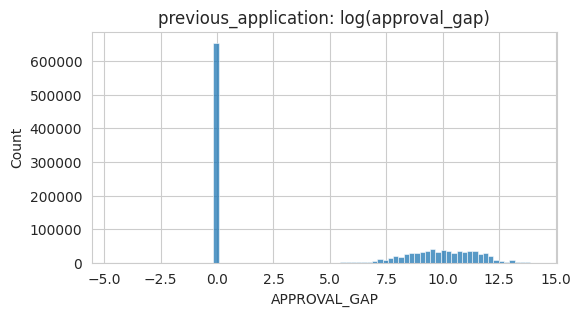

In [ ]:
# @title AMT_APPLICATION vs AMT_CREDIT distribution & gap
if set(['AMT_APPLICATION','AMT_CREDIT']).issubset(prev.columns):
    prev['APPROVAL_GAP'] = prev['AMT_CREDIT'] - prev['AMT_APPLICATION']
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(np.log1p(prev['APPROVAL_GAP'].fillna(0)+1e-6), bins=80, ax=ax)
    ax.set_title("previous_application: log(approval_gap)")
    plt.show()
    plt.close(fig)

In [ ]:
# @title Aggregate to SK_ID_CURR
agg_prev = prev.groupby('SK_ID_CURR').agg(
    prev_count=('SK_ID_PREV','count'),
    prev_amt_app_mean=('AMT_APPLICATION','mean'),
    prev_amt_credit_mean=('AMT_CREDIT','mean'),
    prev_amt_credit_max=('AMT_CREDIT','max'),
    prev_cnt_payment_mean=('CNT_PAYMENT','mean'),
    prev_days_decision_mean=('DAYS_DECISION','mean'),
    prev_approval_gap_mean=('APPROVAL_GAP','mean')
).reset_index()
agg_prev.to_csv(os.path.join(output_path, "prev_agg_per_curr.csv"), index=False)
display(agg_prev.head())

,SK_ID_CURR,prev_count,prev_amt_app_mean,prev_amt_credit_mean,prev_amt_credit_max,prev_cnt_payment_mean,prev_days_decision_mean,prev_approval_gap_mean
0,100001,1,24835.50,23787.00,23787.0,8.0,-1740.0,-1048.5
1,100002,1,179055.00,179055.00,179055.0,24.0,-606.0,0.0
2,100003,3,435436.50,484191.00,1035882.0,10.0,-1305.0,48754.5
3,100004,1,24282.00,20106.00,20106.0,4.0,-815.0,-4176.0
4,100005,2,22308.75,20076.75,40153.5,12.0,-536.0,-2232.0


## EDA (POS_CASH_balance)

In [ ]:
# @title Overview
print("POS_CASH_balance shape:", pos.shape)
print("Total columns:", len(pos.columns))
# Missing values
mr_pos = missing_report(pos, top=None)
display(mr_pos.head(50))
# @title Numeric summary
num_sum_pos = quick_num_summary(pos, top=None)
display(num_sum_pos.head(50))

POS_CASH_balance shape: (10001358, 8)
Total columns: 8


,n_missing,pct
CNT_INSTALMENT_FUTURE,26087,0.26
CNT_INSTALMENT,26071,0.26


,count,mean,std,min,25%,50%,75%,max,na_pct
CNT_INSTALMENT,9975287.0,1.708965e+01,11.995056,1.0,10.0,12.0,24.0,92.0,0.26
CNT_INSTALMENT_FUTURE,9975271.0,1.048384e+01,11.109058,0.0,3.0,7.0,14.0,85.0,0.26
SK_ID_PREV,10001358.0,1.903217e+06,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0,0.00
MONTHS_BALANCE,10001358.0,-3.501259e+01,26.066570,-96.0,-54.0,-28.0,-13.0,-1.0,0.00
SK_ID_CURR,10001358.0,2.784039e+05,102763.745090,100001.0,189550.0,278654.0,367429.0,456255.0,0.00
SK_DPD,10001358.0,1.160693e+01,132.714043,0.0,0.0,0.0,0.0,4231.0,0.00
SK_DPD_DEF,10001358.0,6.544684e-01,32.762491,0.0,0.0,0.0,0.0,3595.0,0.00


In [ ]:
# @title Distribution of Contract Status in POS-CASH Balance Dataset (%)
temp = pos["NAME_CONTRACT_STATUS"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Distribution of Contract Status in POS_CASH_balance (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Contract Status',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Contracts',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Aggregate to SK_ID_CURR
agg_pos = pos.groupby('SK_ID_CURR').agg(
    pos_count=('SK_ID_PREV', 'count'),
    pos_months_balance_mean=('MONTHS_BALANCE', 'mean'),
    pos_months_balance_min=('MONTHS_BALANCE', 'min'),
    pos_months_balance_max=('MONTHS_BALANCE', 'max'),
    pos_sk_dpd_mean=('SK_DPD', 'mean'),
    pos_sk_dpd_max=('SK_DPD', 'max'),
    pos_sk_dpd_def_mean=('SK_DPD_DEF', 'mean'),
    pos_sk_dpd_def_max=('SK_DPD_DEF', 'max')
).reset_index()

agg_pos.to_csv(os.path.join(output_path, "pos_cash_balance_agg_per_curr.csv"), index=False)
display(agg_pos.head())

,SK_ID_CURR,pos_count,pos_months_balance_mean,pos_months_balance_min,pos_months_balance_max,pos_sk_dpd_mean,pos_sk_dpd_max,pos_sk_dpd_def_mean,pos_sk_dpd_def_max
0,100001,9,-72.555556,-96,-53,0.777778,7,0.777778,7
1,100002,19,-10.000000,-19,-1,0.000000,0,0.000000,0
2,100003,28,-43.785714,-77,-18,0.000000,0,0.000000,0
3,100004,4,-25.500000,-27,-24,0.000000,0,0.000000,0
4,100005,11,-20.000000,-25,-15,0.000000,0,0.000000,0


## EDA (credit_card_balance)

In [ ]:
# @title Overview
print("credit_card_balance shape:", cc.shape)
print("Total columns:", len(cc.columns))
# Missing values
mr_cc = missing_report(cc, top=None)
display(mr_cc.head(50))
# Numeric summary
num_sum_cc = quick_num_summary(cc, top=None)
display(num_sum_cc.head(50))

credit_card_balance shape: (3840312, 23)
Total columns: 23


,n_missing,pct
AMT_PAYMENT_CURRENT,767988,20.00
AMT_DRAWINGS_ATM_CURRENT,749816,19.52
AMT_DRAWINGS_OTHER_CURRENT,749816,19.52
AMT_DRAWINGS_POS_CURRENT,749816,19.52
CNT_DRAWINGS_ATM_CURRENT,749816,19.52
CNT_DRAWINGS_POS_CURRENT,749816,19.52
CNT_DRAWINGS_OTHER_CURRENT,749816,19.52
AMT_INST_MIN_REGULARITY,305236,7.95
CNT_INSTALMENT_MATURE_CUM,305236,7.95


,count,mean,std,min,25%,50%,75%,max,na_pct
AMT_PAYMENT_CURRENT,3072324.0,1.028054e+04,36078.084953,0.000,152.37,2702.7,9.000000e+03,4289207.445,20.00
AMT_DRAWINGS_ATM_CURRENT,3090496.0,5.961325e+03,28225.688579,-6827.310,0.00,0.0,0.000000e+00,2115000.000,19.52
CNT_DRAWINGS_ATM_CURRENT,3090496.0,3.094490e-01,1.100401,0.000,0.00,0.0,0.000000e+00,51.000,19.52
AMT_DRAWINGS_POS_CURRENT,3090496.0,2.968805e+03,20796.887047,0.000,0.00,0.0,0.000000e+00,2239274.160,19.52
AMT_DRAWINGS_OTHER_CURRENT,3090496.0,2.881696e+02,8201.989345,0.000,0.00,0.0,0.000000e+00,1529847.000,19.52
CNT_DRAWINGS_OTHER_CURRENT,3090496.0,4.812496e-03,0.082639,0.000,0.00,0.0,0.000000e+00,12.000,19.52
CNT_DRAWINGS_POS_CURRENT,3090496.0,5.594791e-01,3.240649,0.000,0.00,0.0,0.000000e+00,165.000,19.52
CNT_INSTALMENT_MATURE_CUM,3535076.0,2.082508e+01,20.051494,0.000,4.00,15.0,3.200000e+01,120.000,7.95
AMT_INST_MIN_REGULARITY,3535076.0,3.540204e+03,5600.154122,0.000,0.00,0.0,6.633911e+03,202882.005,7.95
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,1.538080e+05,165145.699523,0.000,45000.00,112500.0,1.800000e+05,1350000.000,0.00


In [ ]:
# @title Distribution of Contract Status in Credit Card Balance (%)
temp = cc["NAME_CONTRACT_STATUS"].value_counts()
percent = (temp / temp.sum()) * 100
trace = go.Bar(x=temp.index, y=percent, marker=dict(color='rgb(203, 85, 132)'))
layout = go.Layout(title=dict(text="Distribution of Contract Status in Credit Card Balance (%)",
                              x=0.5, xanchor='center', yanchor='top', font=dict(size=14, color='black')),
                   xaxis=dict(title='Contract Status',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   yaxis=dict(title='Percentage of Contracts',
                              titlefont=dict(size=12, color='rgb(1,1,1)'),
                              tickfont=dict(size=10, color='rgb(1,1,1)'),
                              showgrid=False, showline=True, linecolor='rgb(1,1,1)', linewidth=1),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [ ]:
# @title Credit utilization analysis
if set(['AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL']).issubset(cc.columns):
    cc['UTIL'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL'].replace(0,np.nan)
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(cc['UTIL'].dropna().clip(upper=5), bins=100, ax=ax)
    ax.set_title("credit_card_balance: UTIL (clipped)")
    plt.close(fig)

In [ ]:
# @title Aggregation to SK_ID_CURR
agg_cc = cc.groupby('SK_ID_CURR').agg(
    cc_count=('SK_ID_PREV', 'count'),
    cc_util_mean=('UTIL', 'mean'),
    cc_util_max=('UTIL', 'max'),
    cc_amt_balance_mean=('AMT_BALANCE', 'mean'),
    cc_amt_balance_max=('AMT_BALANCE', 'max'),
    cc_amt_payment_total_mean=('AMT_PAYMENT_TOTAL_CURRENT', 'mean'),
    cc_amt_payment_total_max=('AMT_PAYMENT_TOTAL_CURRENT', 'max'),
    cc_amt_total_receivable_mean=('AMT_TOTAL_RECEIVABLE', 'mean'),
    cc_amt_drawings_mean=('AMT_DRAWINGS_CURRENT', 'mean'),
    cc_months_balance_min=('MONTHS_BALANCE', 'min'),
    cc_months_balance_max=('MONTHS_BALANCE', 'max')
).reset_index()

agg_cc.to_csv(os.path.join(output_path, "credit_card_balance_agg_per_curr.csv"), index=False)
display(agg_cc.head())

,SK_ID_CURR,cc_count,cc_util_mean,cc_util_max,cc_amt_balance_mean,cc_amt_balance_max,cc_amt_payment_total_mean,cc_amt_payment_total_max,cc_amt_total_receivable_mean,cc_amt_drawings_mean,cc_months_balance_min,cc_months_balance_max
0,100006,6,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,-6,-1
1,100011,74,0.302678,1.05000,54482.111149,189000.00,4520.067568,55485.0,54433.179122,2432.432432,-75,-2
2,100013,96,0.115301,1.02489,18159.919219,161420.22,6817.172344,153675.0,18101.079844,5953.125000,-96,-1
3,100021,17,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,-18,-2
4,100023,8,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,-11,-4


## EDA (installments_payments)

In [ ]:
# @title Overview
print("installments_payments shape:", ins.shape)
print("Total columns:", len(ins.columns))
# @title Missing Value
mr_ins = missing_report(ins, top=None)
display(mr_ins.head(50))
# @title Numeric Summary
num_sum_ins = quick_num_summary(ins, top=None)
display(num_sum_ins.head(50))

installments_payments shape: (13605401, 8)
Total columns: 8


,n_missing,pct
DAYS_ENTRY_PAYMENT,2905,0.02
AMT_PAYMENT,2905,0.02


,count,mean,std,min,25%,50%,75%,max,na_pct
AMT_PAYMENT,13602496.0,1.723822e+04,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845,0.02
DAYS_ENTRY_PAYMENT,13602496.0,-1.051114e+03,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000,0.02
SK_ID_PREV,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.000,1896520.000,2369094.000,2843499.000,0.00
SK_ID_CURR,13605401.0,2.784449e+05,102718.310411,100001.0,189639.000,278685.000,367530.000,456255.000,0.00
NUM_INSTALMENT_NUMBER,13605401.0,1.887090e+01,26.664067,1.0,4.000,8.000,19.000,277.000,0.00
NUM_INSTALMENT_VERSION,13605401.0,8.566373e-01,1.035216,0.0,0.000,1.000,1.000,178.000,0.00
DAYS_INSTALMENT,13605401.0,-1.042270e+03,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000,0.00
AMT_INSTALMENT,13605401.0,1.705091e+04,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845,0.00


In [ ]:
# @title Payment Ratio Analysis
if set(['AMT_INSTALMENT','AMT_PAYMENT']).issubset(ins.columns):
    ins['PAY_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT'].replace(0,np.nan)
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(ins['PAY_RATIO'].dropna().clip(0,3), bins=100, ax=ax)
    ax.set_title("installments_payments: PAY_RATIO (clipped)")
    plt.close(fig)

In [ ]:
# @title Lateness Calculation
if set(['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT','AMT_INSTALMENT','AMT_PAYMENT']).issubset(ins.columns):
    ins['DAYS_LATE'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['LATE_FLAG'] = (ins['DAYS_LATE'] > 0).astype(int)
    late_rate = ins['LATE_FLAG'].mean()
    print("Late payment rate (rows):", late_rate)
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(ins['DAYS_LATE'].dropna().clip(-30,200), bins=100, ax=ax)
    ax.set_title("installments_payments: DAYS_LATE (clipped)")
    plt.close(fig)
    # Late payment proportion
    late_ct = ins['LATE_FLAG'].value_counts()
    fig, ax = plt.subplots(figsize=(4,3))
    sns.barplot(x=late_ct.index, y=late_ct.values, ax=ax)
    ax.set_title("installments_payments: Late vs On-time counts")
    plt.close(fig)

Late payment rate (rows): 0.08428042657471103


In [ ]:
# @title Aggregation to SK_ID_CURR
agg_ins = ins.groupby('SK_ID_CURR').agg(
    ins_count=('SK_ID_PREV','count'),
    ins_amt_instalment_mean=('AMT_INSTALMENT','mean'),
    ins_amt_instalment_sum=('AMT_INSTALMENT','sum'),
    ins_amt_payment_mean=('AMT_PAYMENT','mean'),
    ins_amt_payment_sum=('AMT_PAYMENT','sum'),
    ins_pay_ratio_mean=('PAY_RATIO','mean'),
    ins_pay_ratio_max=('PAY_RATIO','max'),
    ins_days_late_mean=('DAYS_LATE','mean'),
    ins_days_late_max=('DAYS_LATE','max'),
    ins_late_rate=('LATE_FLAG','mean')
).reset_index()

agg_ins.to_csv(os.path.join(output_path, "installments_payments_agg_per_curr.csv"), index=False)
display(agg_ins.head())

,SK_ID_CURR,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,100001,7,5885.132143,41195.925,5885.132143,41195.925,1.0,1.0,-7.285714,11.0,0.142857
1,100002,19,11559.247105,219625.695,11559.247105,219625.695,1.0,1.0,-20.421053,-12.0,0.000000
2,100003,25,64754.586000,1618864.650,64754.586000,1618864.650,1.0,1.0,-7.160000,-1.0,0.000000
3,100004,3,7096.155000,21288.465,7096.155000,21288.465,1.0,1.0,-7.666667,-3.0,0.000000
4,100005,9,6240.205000,56161.845,6240.205000,56161.845,1.0,1.0,-23.555556,1.0,0.111111


# **Feature Engineering (Merge Aggregation Results)**

In [ ]:
# Merge to application_train
df_train_merged = (
    app_train.copy()
    .merge(agg_bureau, on='SK_ID_CURR', how='left')
    .merge(agg_prev, on='SK_ID_CURR', how='left')
    .merge(agg_pos, on='SK_ID_CURR', how='left')
    .merge(agg_cc, on='SK_ID_CURR', how='left')
    .merge(agg_ins, on='SK_ID_CURR', how='left')
)

# Merge to application_test
df_test_merged = (
    app_test.copy()
    .merge(agg_bureau, on='SK_ID_CURR', how='left')
    .merge(agg_prev, on='SK_ID_CURR', how='left')
    .merge(agg_pos, on='SK_ID_CURR', how='left')
    .merge(agg_cc, on='SK_ID_CURR', how='left')
    .merge(agg_ins, on='SK_ID_CURR', how='left')
)

# Info ukuran dataset
print("Train shape after merging:", df_train_merged.shape)
print("Test shape after merging:", df_test_merged.shape)

# Simpan hasil merge
df_train_merged.to_csv(os.path.join(output_path, "train_merged.csv"), index=False)
df_test_merged.to_csv(os.path.join(output_path, "test_merged.csv"), index=False)

print("✅ Merging selesai, file disimpan di:", output_path)

Train shape after merging: (307511, 175)
Test shape after merging: (48744, 174)
✅ Merging selesai, file disimpan di: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern//Outputs/EDA Outputs


In [ ]:
# Tampilkan sample hasil merge
print("\n📌 Train dataset preview:")
display(df_train_merged.head())

print("\n📌 Test dataset preview:")
display(df_test_merged.head())


📌 Train dataset preview:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,11559.247105,219625.695,11559.247105,219625.695,1.000000,1.0,-20.421053,-12.0,0.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,25.0,64754.586000,1618864.650,64754.586000,1618864.650,1.000000,1.0,-7.160000,-1.0,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,3.0,7096.155000,21288.465,7096.155000,21288.465,1.000000,1.0,-7.666667,-3.0,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,16.0,62947.088438,1007153.415,62947.088438,1007153.415,1.000000,1.0,-19.375000,-1.0,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,12666.444545,835985.340,12214.060227,806127.975,0.954545,1.0,-3.636364,12.0,0.242424



📌 Test dataset preview:


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ins_count,ins_amt_instalment_mean,ins_amt_instalment_sum,ins_amt_payment_mean,ins_amt_payment_sum,ins_pay_ratio_mean,ins_pay_ratio_max,ins_days_late_mean,ins_days_late_max,ins_late_rate
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,7.0,5885.132143,41195.925,5885.132143,41195.925,1.000000,1.0,-7.285714,11.0,0.142857
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,9.0,6240.205000,56161.845,6240.205000,56161.845,1.000000,1.0,-23.555556,1.0,0.111111
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,155.0,10897.898516,1689174.270,9740.235774,1509736.545,0.935484,1.0,-5.180645,21.0,0.070968
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,113.0,4979.282257,562658.895,4356.731549,492310.665,0.911504,1.0,-3.000000,7.0,0.106195
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,12.0,11100.337500,133204.050,11100.337500,133204.050,1.000000,1.0,-12.250000,-9.0,0.000000
